In [ ]:
#%%

#
# 60/40 portfolio on optimized MA cross parameters using RealTest software
#
#

import norgatedata
import quantstats        as qs
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

[2024-04-16 04:51:31.188024] INFO: Norgate Data: NorgateData package v1.0.74: Init complete


In [ ]:
#%%

# Preparing data using Norgate

# Stocks
spy_df = norgatedata.price_timeseries(
    "SPY",
    stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
    padding_setting                = norgatedata.PaddingType.NONE,
    start_date                     = "1990-01-01",
    timeseriesformat               = 'pandas-dataframe',
)

# Bonds
agg_df = norgatedata.price_timeseries(
    "AGG",
    stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
    padding_setting                = norgatedata.PaddingType.NONE,
    start_date                     = "1990-01-01",
    timeseriesformat               = 'pandas-dataframe',
)

In [ ]:
#%%

def macross_backtest(df_, ma_fast, ma_slow):
    df = df_.copy()
    df['FillPrice'] = df['Open' ].shift(-1)
    df['Date'     ] = df.index
    df['DateIn'   ] = df['Date' ].shift(-1)
    df['DateOut'  ] = df['Date' ].shift(-1)
    df.fillna(method='ffill', inplace=True)
    df['EntrySetup'] = 0
    df['ExitRule'  ] = 0
    df['MaFast'] = df['Close'].rolling(ma_fast).mean()
    df['MaSlow'] = df['Close'].rolling(ma_slow).mean()
    df.dropna(inplace=True)
    df.loc[((df['MaFast']>df['MaSlow']) & (df['MaFast'].shift(1)<=df['MaSlow'].shift(1))), 'EntrySetup'] = 1
    df.loc[((df['MaFast']<df['MaSlow']) & (df['MaFast'].shift(1)>=df['MaSlow'].shift(1))), 'ExitRule'  ] = 1
    df.loc[df.index[ 0], 'EntrySetup'] = 1
    df.loc[df.index[-1], 'ExitRule'  ] = 1

    # Position tracking
    in_position      = False
    date_in          = None
    entry_fill_price = 0
    date_out         = None
    exit_fill_price  = 0
    position_history = []
    for index, row in df.iterrows():
        # EntrySetup
        if row['EntrySetup'] == 1:
            date_in          = row['DateIn'   ]
            entry_fill_price = row['FillPrice']
        # ExitRuel
        if row['ExitRule'  ] == 1:
            date_out        = row['DateOut'  ]
            exit_fill_price = row['FillPrice']
            pct_change      = (exit_fill_price - entry_fill_price)/entry_fill_price
            bars            = len(df[date_in:date_out])-1
            position_history.append((
                date_in, 
                date_out, 
                entry_fill_price, 
                exit_fill_price, 
                pct_change,
                bars
                ))

    position_df = pd.DataFrame(position_history, columns=['DateIn', 'DateOut', 'PriceIn', 'PriceOut', 'Return', 'Bars'])
    position_df = position_df.set_index(pd.DatetimeIndex(position_df['DateIn']))

    df['Return'] = df['Close'].pct_change()

    df['StratReturn'] = 0.0
    for index, row in position_df.iterrows():
        sub_df = df[row['DateIn']:row['DateOut']]["Return"]
        df.loc[sub_df.index, 'StratReturn'] = sub_df

    return df['StratReturn']

<ipython-input-4-f107bd5ed5a4>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


<Axes: xlabel='Date'>

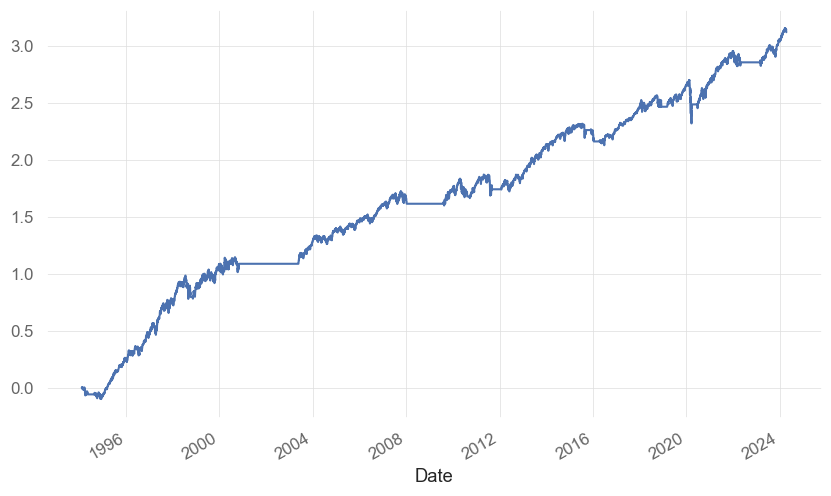

In [ ]:
#%%

spy_df['StratRet'] = macross_backtest(spy_df, ma_fast=40, ma_slow=260)
spy_df['StratRet'].cumsum().plot()

<ipython-input-4-f107bd5ed5a4>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


<Axes: xlabel='Date'>

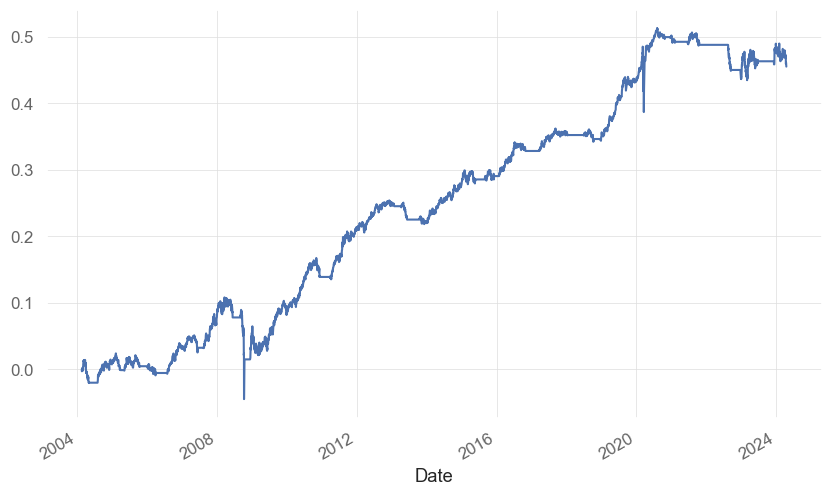

In [ ]:
#%%

agg_df['StratRet'] = macross_backtest(agg_df, ma_fast=30, ma_slow=100)
agg_df['StratRet'].cumsum().plot()

In [ ]:
#%%

qs.stats.sharpe(spy_df['StratRet']), qs.stats.sharpe(agg_df['StratRet'])

(0.7332667704960615, 0.5257334501110028)

<Axes: xlabel='Date'>

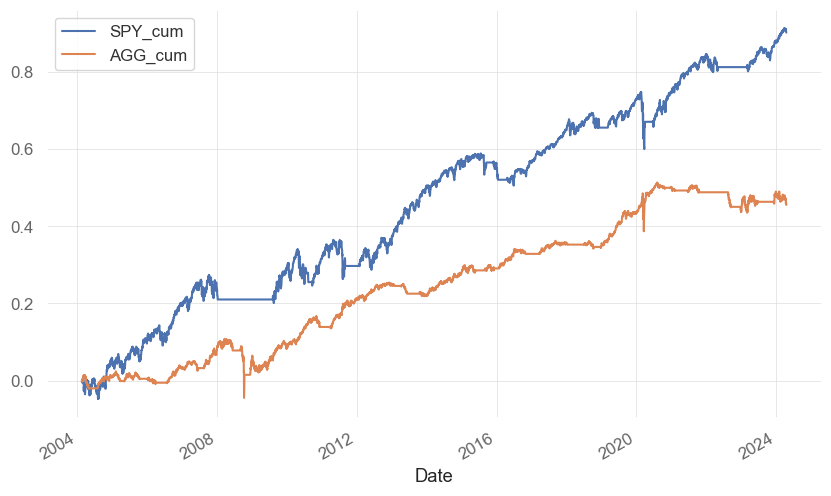

In [ ]:
#%%

df = pd.DataFrame(index=spy_df.index)
df['SPY_ret'] = spy_df['StratRet']
df['AGG_ret'] = agg_df['StratRet']
df['SPY_cum'] = df['SPY_ret'].cumsum()
df['AGG_cum'] = df['AGG_ret'].cumsum()

df.dropna(inplace=True)

df['SPY_ret'] = df['SPY_cum'].pct_change()
df['SPY_cum'] = df['SPY_ret'].cumsum()

df[['SPY_cum', 'AGG_cum']].plot()

In [ ]:
#%%

# 2 BPS for trading cost proxy using Interactive Brokers fee model, very optimistic
rebalancing_cost        = 0.02/100.0
rebalancing_cost_log    = np.log(1-rebalancing_cost)

previous_rebalance_date = None
rebalance_frequency     = 'W-MON' # Weekly rebalance
stock_weight            = 0.6
bond_weight             = 0.4
portfolio_dates         = []
portfolio_returns       = []

for date, group in df.groupby(pd.Grouper(freq=rebalance_frequency)):
    group_df = group.copy()
    group_df['SPY_freq_cum'] = group_df['SPY_ret'].cumsum()
    group_df['AGG_freq_cum'] = group_df['AGG_ret'].cumsum()
    return_at_rebalance = stock_weight * group_df.iloc[-1]['SPY_freq_cum'] + bond_weight * group_df.iloc[-1]['AGG_freq_cum']
    portfolio_dates.append(date)
    portfolio_returns.append(return_at_rebalance)

portfolio_df = pd.DataFrame(index=portfolio_dates)
portfolio_df.index = pd.to_datetime(portfolio_df.index)
portfolio_df['ret'             ] = portfolio_returns
portfolio_df['log_ret'         ] = (1+portfolio_df['ret']).apply(np.log)
portfolio_df['adjusted_log_ret'] = portfolio_df['log_ret'] + rebalancing_cost_log
portfolio_df['cum'             ] = portfolio_df['log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_cum'    ] = portfolio_df['adjusted_log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_ret'    ] = portfolio_df['adjusted_cum'].pct_change()

portfolio_df

,ret,log_ret,adjusted_log_ret,cum,adjusted_cum,adjusted_ret
2004-02-23,-0.002671,-0.002674,-0.002874,0.997329,0.997130,NaN
2004-03-01,0.007387,0.007359,0.007159,1.004696,1.004294,0.007185
2004-03-08,-0.001158,-0.001159,-0.001359,1.003533,1.002931,-0.001358
2004-03-15,-0.015089,-0.015204,-0.015404,0.988390,0.987600,-0.015286
2004-03-22,-0.003702,-0.003709,-0.003909,0.984731,0.983747,-0.003902
...,...,...,...,...,...,...
2024-03-18,-0.003534,-0.003541,-0.003741,2.041466,1.655408,-0.003734
2024-03-25,0.005207,0.005194,0.004994,2.052097,1.663695,0.005006
2024-04-01,-0.000795,-0.000795,-0.000995,2.050466,1.662040,-0.000995
2024-04-08,-0.002661,-0.002665,-0.002865,2.045009,1.657286,-0.002861


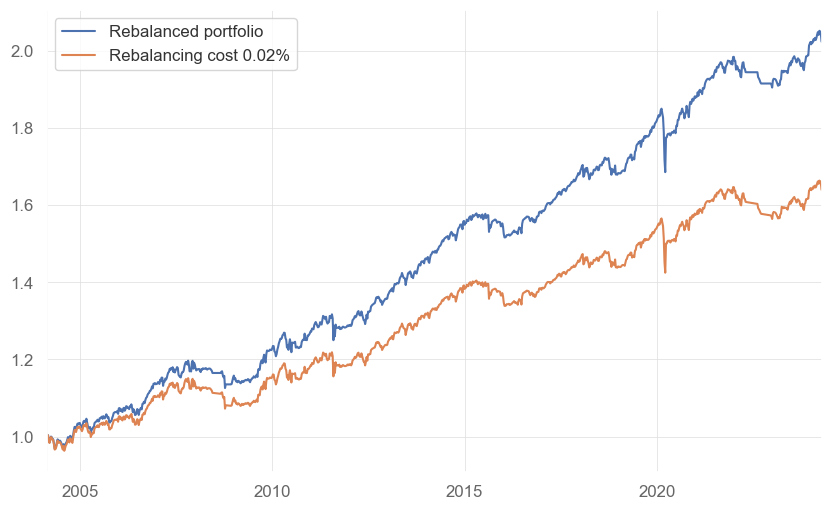

In [ ]:
#%%

portfolio_df[['cum', 'adjusted_cum']].plot()
plt.legend(['Rebalanced portfolio', f"Rebalancing cost {round(rebalancing_cost*100,2)}%"])

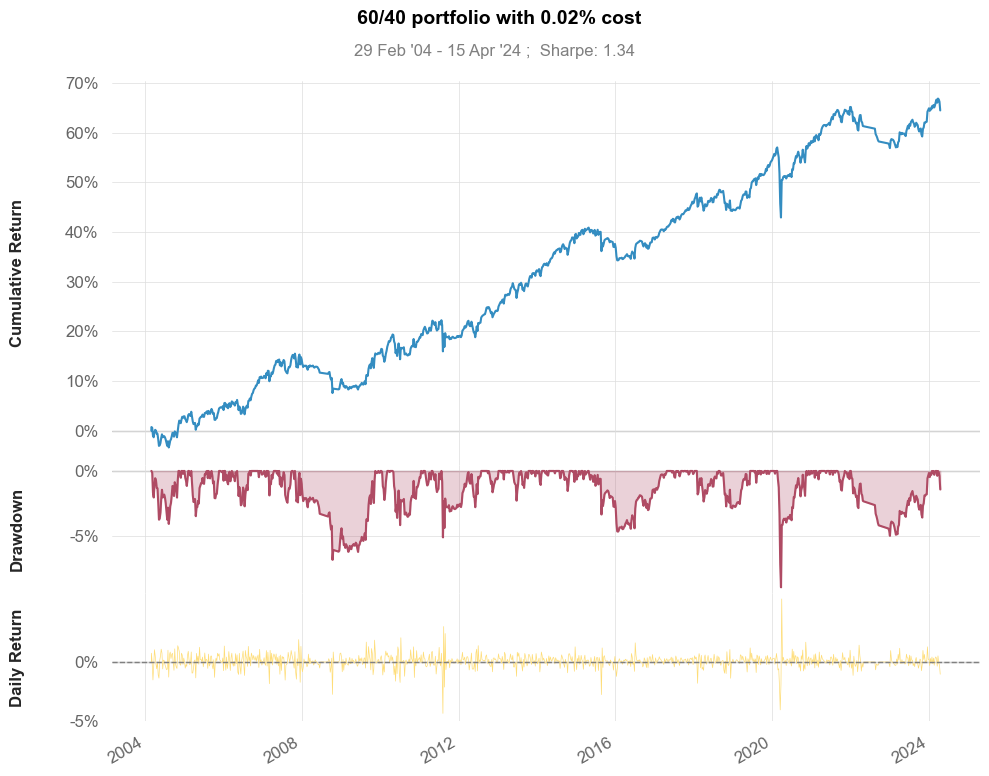

In [ ]:
#%%

qs.plots.snapshot(portfolio_df['adjusted_ret'], title=f"60/40 portfolio with {round(rebalancing_cost*100,2)}% cost", show=True);

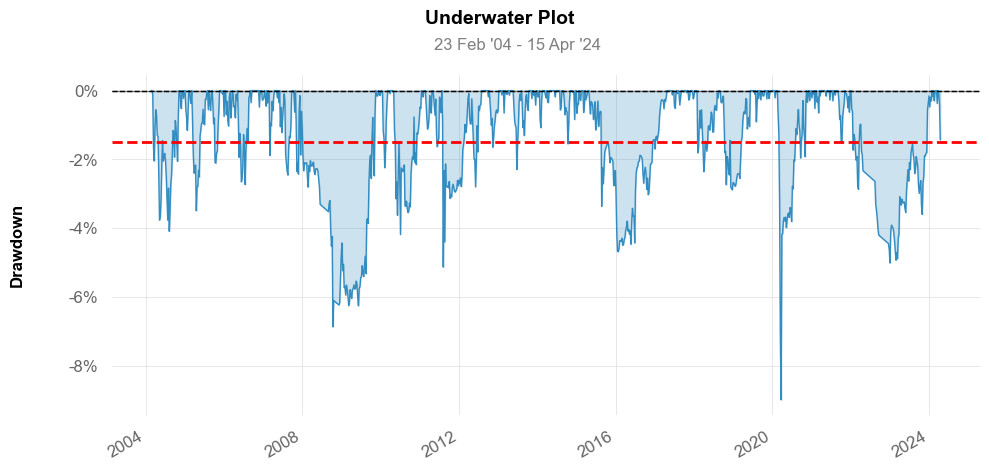

In [ ]:
#%%

qs.plots.drawdown(portfolio_df['adjusted_ret'])

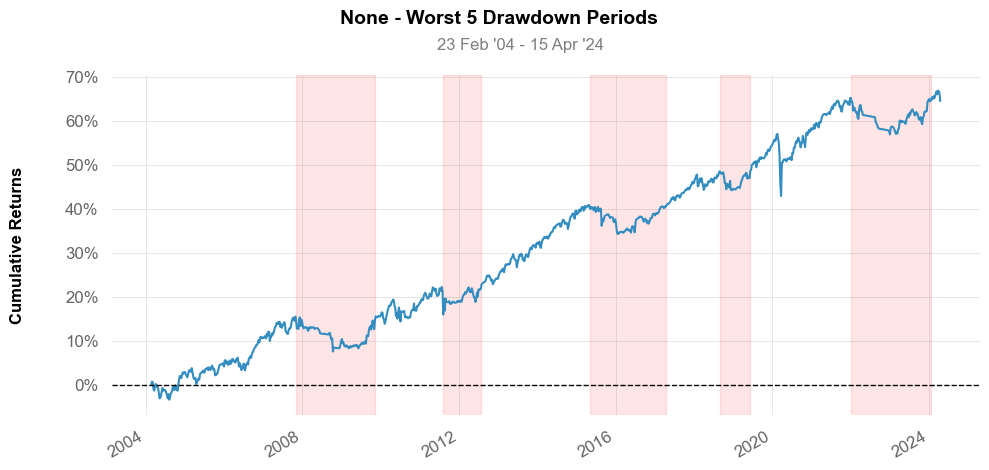

In [ ]:
#%%

qs.plots.drawdowns_periods(portfolio_df['adjusted_ret'])

c:\src\dev\hello-60-40\env\lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


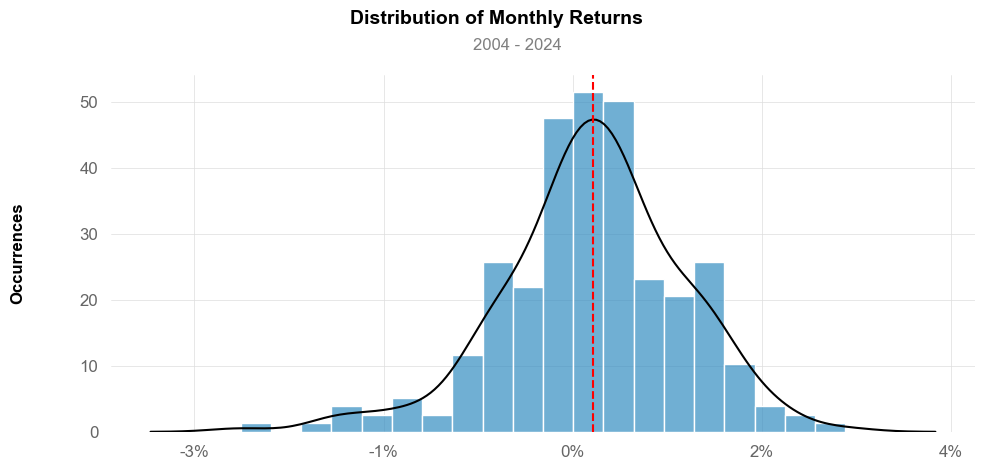

In [ ]:
#%%

qs.plots.histogram(portfolio_df['adjusted_ret'])

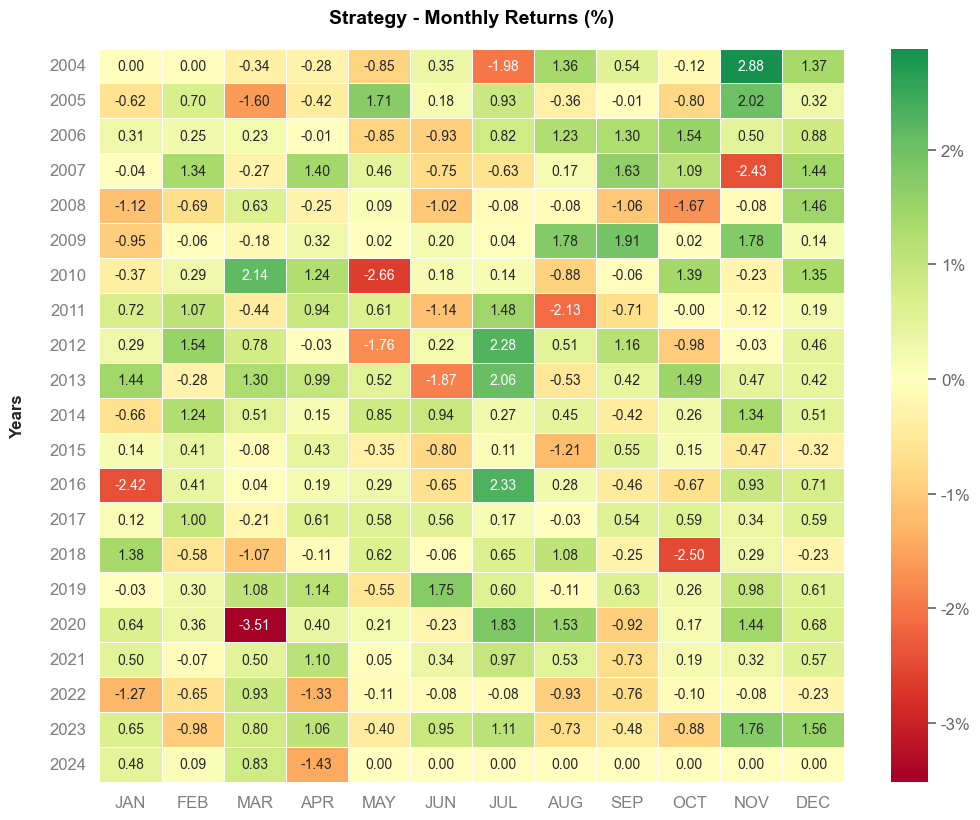

In [ ]:
#%%

qs.plots.monthly_heatmap(portfolio_df['adjusted_ret'])

c:\src\dev\hello-60-40\env\lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\src\dev\hello-60-40\env\lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


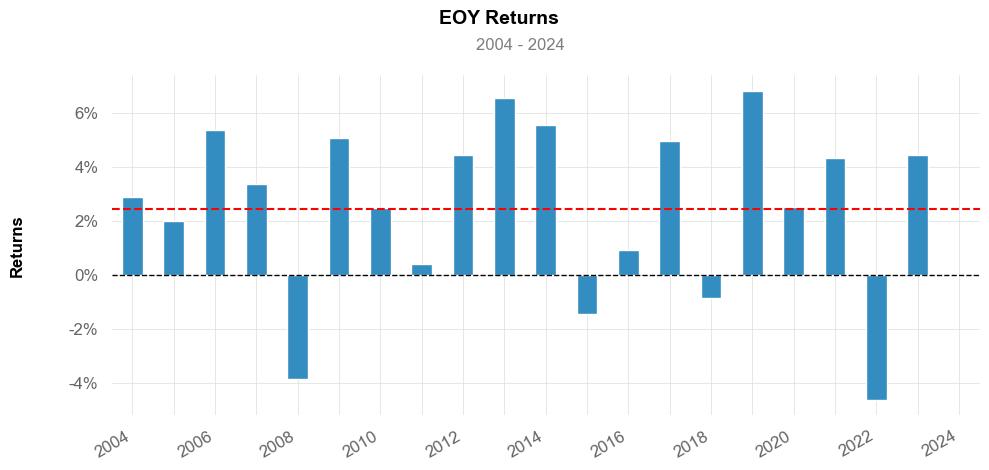

In [ ]:
#%%

qs.plots.yearly_returns(portfolio_df['adjusted_ret'])

In [ ]:
#%%

qs.stats.sharpe(portfolio_df['adjusted_ret'])

1.3402073017957137

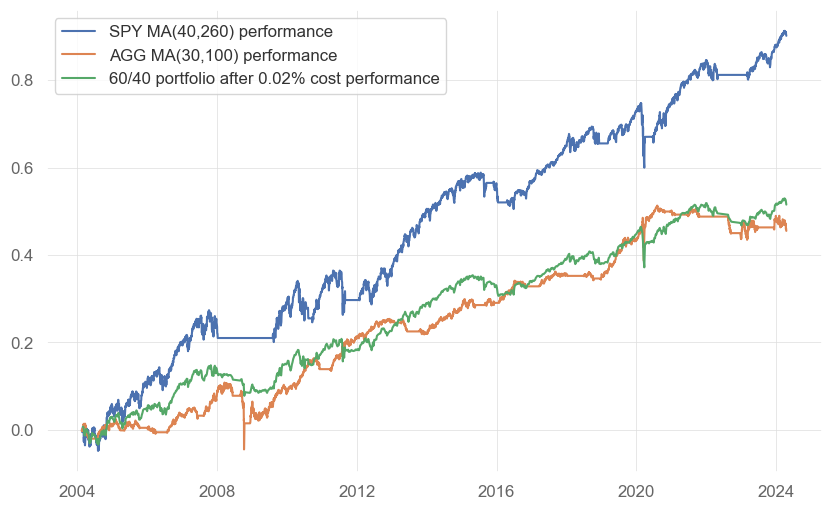

In [ ]:
#%%

plt.plot(df['SPY_cum'])
plt.plot(df['AGG_cum'])
plt.plot(portfolio_df['adjusted_ret'].cumsum())
plt.legend(['SPY MA(40,260) performance', 'AGG MA(30,100) performance', f"60/40 portfolio after {round(rebalancing_cost*100.0, 2)}% cost performance"])
plt.show()